# Visualize ICESat-2 ATL07 Data

ICESat-2 hackweek final project  
June 16, 2020  
Nicole Abib

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py
from scipy.interpolate import interp1d
from astropy.time import Time
import sys  
sys.path.insert(0, '/home/jovyan/leading_to_phytoplankton/scripts')
import readers as rd

%matplotlib inline

In [2]:
# Import ATL07 Data
beam='gt1l' # Beam of interest
temp_dloc = '/home/jovyan/'
is2_fn = 'ATL07-02_20190812170458_06970401_003_02.h5'
is2_f = h5py.File(temp_dloc+is2_fn, 'r')
df07= rd.getATL07(is2_f,beam)
df07.head()
print(is2_f['orbit_info/sc_orient'][0]) # Check forward/backward orientation

0


In [3]:
# Import ATL03 Data from the same RGT for comparison
is2_fn='ATL03_20190812180506_06970410_003_01.h5'
is2_f = h5py.File(temp_dloc+is2_fn, 'r')
df03=rd.getATL03(is2_f, beam)
df03.head()

,lats,lons,x,y,heights,dt,conf
0,-50.033752,-76.570178,25642162.0,3378.286133,-235.189667,5.086831e+07,-1
1,-50.033752,-76.570180,25642162.0,3378.146729,-216.516129,5.086831e+07,-1
2,-50.033758,-76.570181,25642162.0,3378.145020,-216.363556,5.086831e+07,-1
3,-50.033759,-76.570179,25642162.0,3378.280518,-234.496429,5.086831e+07,-1
4,-50.033764,-76.570182,25642164.0,3378.126709,-213.995193,5.086831e+07,-1


## Look at a smaller section

In [6]:
lonmin,lonmax,latmin,latmax= [-90,-30,-65.1,-65]
region=(df07.lats>latmin)&(df07.lats<latmax)&(df07.lons>lonmin)&(df07.lons<lonmax)
df07_cut=df07[region]
# cut df03 to region of interest
region=(df03.lats>latmin)&(df03.lats<latmax)&(df03.lons>lonmin)&(df03.lons<lonmax)
df03_cut=df03[region]

# Apply vertical corrections to ATL03 to allow comparison

In [7]:
# mean sea surface correction - interpolating time with corrections
mss_corr=interp1d(df07.dt.values,df07.mss.values)
# inverted barometer correction
ib_corr=interp1d(df07.dt.values,df07.ib.values)
# ocean tide correction
ocean_corr=interp1d(df07.dt.values,df07.ocean.values)
# long period equilibrium tide correction
lpe_corr=interp1d(df07.dt.values,df07.lpe.values)

# Apply corrections  at sampling rate of dt from atl03
df03_cut['correction']=mss_corr(df03_cut.dt.values)+ib_corr(df03_cut.dt.values)+ocean_corr(df03_cut.dt.values)+lpe_corr(df03_cut.dt.values)
df03_cut['height_corr']=df03_cut.heights-df03_cut.correction # subtract correction from ATL03 heights
df03_cut.head()


,lats,lons,x,y,heights,dt,conf,correction,height_corr
1215903,-65.000000,-79.431310,27317430.0,3392.105469,-0.577764,5.086854e+07,1,-6.280125,5.702361
1215904,-65.000001,-79.431309,27317430.0,3392.146729,-5.976362,5.086854e+07,4,-6.280125,0.303763
1215905,-65.000001,-79.431309,27317430.0,3392.154785,-7.006761,5.086854e+07,3,-6.280125,-0.726635
1215906,-65.000001,-79.431309,27317430.0,3392.149902,-6.384131,5.086854e+07,4,-6.280125,-0.104006
1215907,-65.000001,-79.431309,27317430.0,3392.146240,-5.892985,5.086854e+07,4,-6.280125,0.387140


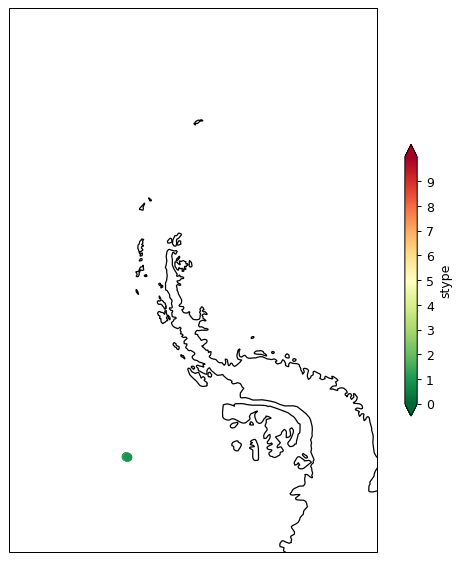

In [30]:
var= 'stype' 

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=10
ticks=np.arange(vmin,vmax,1)

plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
# ax.set_extent([-80,-40,80,86], ccrs.PlateCarree())
ax.set_extent([-90, -30, -60, -65], ccrs.PlateCarree())
plt.scatter(df07_cut['lons'][::100], df07_cut['lats'][::100],c=df07_cut[var][::100], cmap=plt.cm.get_cmap('RdYlGn').reversed(), vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both');

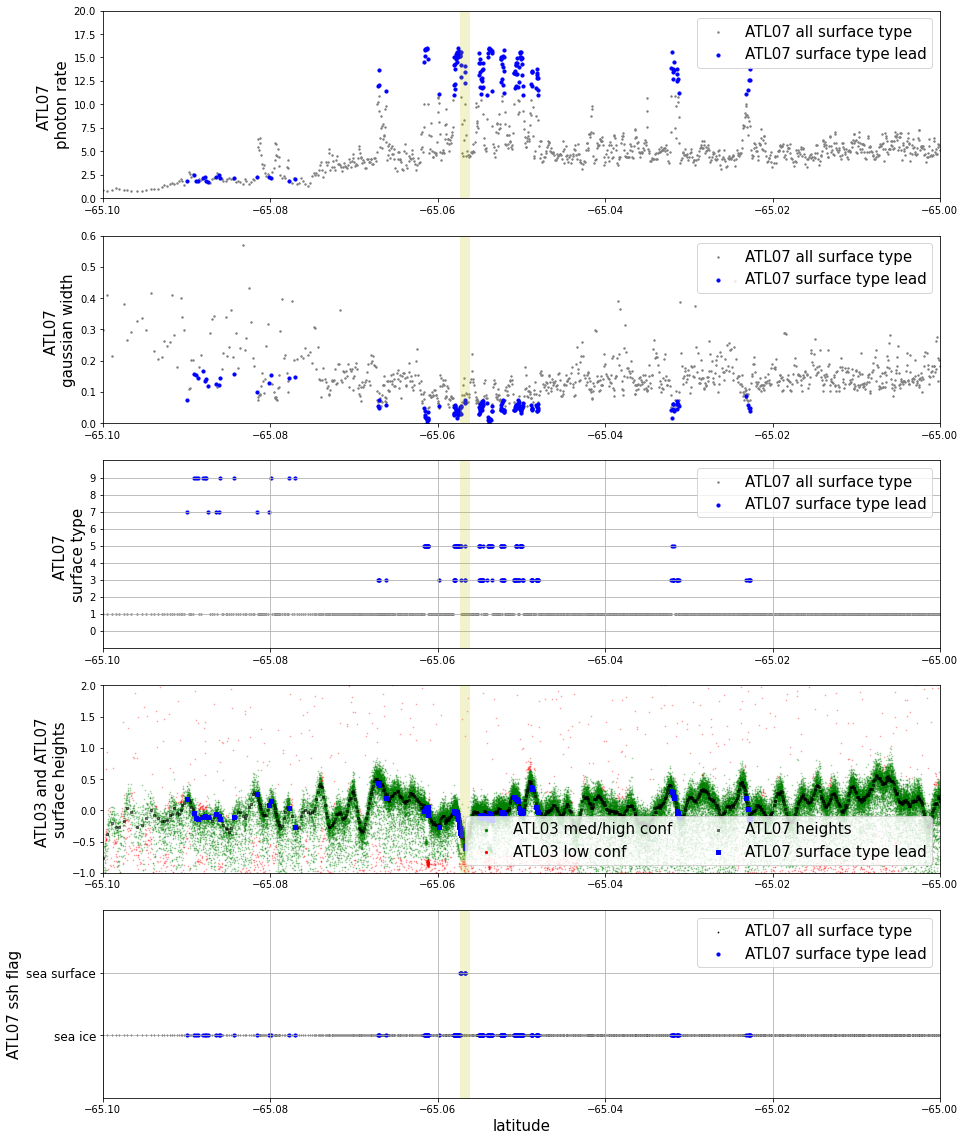

In [31]:
fig,ax=plt.subplots(5,1,figsize=(15,20))

ax[0].scatter(df07_cut.lats,df07_cut.photon_rate,s=2,c='gray', label='ATL07 all surface type')
ax[0].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].photon_rate,s=10,c='b', label= 'ATL07 surface type lead')
ax[0].legend(fontsize=15)
ax[0].set_ylim(0,20)
ax[0].set_ylabel('ATL07 \nphoton rate',fontsize=15)

ax[1].scatter(df07_cut.lats,df07_cut.gauss,s=2,c='gray', label='ATL07 all surface type')
ax[1].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].gauss,s=10,c='blue',label= 'ATL07 surface type lead')
ax[1].legend(loc=1,fontsize=15)
ax[1].set_ylabel('ATL07 \ngaussian width',fontsize=15)
ax[1].set_ylim(0,.6)

ax[2].grid()
ax[2].scatter(df07_cut.lats,df07_cut.stype,s=2,c='gray',label='ATL07 all surface type')
ax[2].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].stype,s=10,c='blue',label= 'ATL07 surface type lead')
ax[2].legend(fontsize=15)
ax[2].set_ylim(-1,10)
ax[2].set_ylabel('ATL07 \nsurface type',fontsize=15)
ax[2].set_yticks(np.arange(0,10,1))

ax[3].scatter(df03_cut.lats[df03_cut.conf<3],df03_cut.height_corr[df03_cut.conf<3],c='r',s=.5,alpha=.3)
ax[3].scatter(df03_cut.lats[df03_cut.conf>2],df03_cut.height_corr[df03_cut.conf>2],c='g',s=.5,alpha=.3)
ax[3].scatter(0,0,c='g',s=5,alpha=1, label = 'ATL03 med/high conf')
ax[3].scatter(0,0,c='r',s=5,alpha=1, label= "ATL03 low conf")

ax[3].scatter(df07_cut.lats,df07_cut.heights,marker='s',s=5,c='k',alpha=.5, label= 'ATL07 heights')
ax[3].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].heights,marker='s',s=10,c='b', label= 'ATL07 surface type lead')
ax[3].legend(ncol=2, loc=4,fontsize=15)
ax[3].set_ylim(-1,2)
ax[3].set_ylabel('ATL03 and ATL07 \nsurface heights',fontsize=15)

ax[4].scatter(df07_cut.lats,df07_cut.ssh_flag,c='k',s=2,marker='.',label='ATL07 all surface type')
ax[4].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].ssh_flag,c='b',s=10,label='ATL07 surface type lead')
ax[4].legend(fontsize=15)
ax[4].grid()
ax[4].set_ylim(-1,2)
ax[4].set_yticks(np.arange(0,2,1))
ax[4].set_yticklabels(['sea ice', 'sea surface'],fontsize=12)
ax[4].set_ylabel('ATL07 ssh flag',fontsize=15)

ax[4].set_xlabel('latitude',fontsize=15)

for a in np.arange(0,5):
    ax[a].set_xlim(latmin,latmax)
    ax[a].axvline(df07_cut[df07_cut.ssh_flag==1].lats.values[0],c='y',alpha=.2, linewidth=10)

